In [1]:
from vmc_torch.hamiltonian_torch import Graph, Spin, Hamiltonian
from autoray import do
import numpy as np
class HoneycombLattice(Graph):
    def __init__(self, Lx, Ly, pbc=False, site_index_map=lambda i, j, Lx, Ly: i * Ly + j):
        """
        Honeycomb lattice using 'Brick Wall' geometry.
        
        Geometry:
            Mapped to a 2D grid (Lx, Ly).
            - Horizontal edges: Connect (i, j) <-> (i, j+1) everywhere.
            - Vertical edges: Connect (i, j) <-> (i+1, j) only if (i + j) % 2 == 0.
            
        Args:
            Lx (int): Number of rows (vertical height).
            Ly (int): Number of columns (horizontal width).
            pbc (bool): Periodic boundary conditions.
            site_index_map (func): Function mapping 2D coordinates to 1D index.
        """
        self.Lx = Lx
        self.Ly = Ly
        self.n_nodes = Lx * Ly
        self.pbc = pbc
        self._site_index_map = site_index_map

        # Generate edges manually (Brick Wall structure)
        # Note: We replace the external qtn.edges dependency to make it standalone 
        # while keeping the logic strictly consistent with honeycomb topology.
        geometric_edges = []
        for i in range(Lx):
            for j in range(Ly):
                # 1. Horizontal edges (Intra-row)
                # Always present in brick wall representation
                if self.pbc or j + 1 < Ly:
                    next_j = (j + 1) % Ly
                    geometric_edges.append(((i, j), (i, next_j)))

                # 2. Vertical edges (Inter-row)
                # Staggered to create hexagons. 
                # Condition (i + j) % 2 == 0 creates the standard honeycomb pattern.
                if (i + j) % 2 == 0:
                    if self.pbc or i + 1 < Lx:
                        next_i = (i + 1) % Lx
                        geometric_edges.append(((i, j), (next_i, j)))

        # Convert geometric coordinates to 1D indices
        self._edges = [
            (site_index_map(*site_i, Lx, Ly), site_index_map(*site_j, Lx, Ly)) 
            for site_i, site_j in geometric_edges
        ]

        # Categorize edges for samplers (Row vs Column)
        # This structure helps in separating 2-site gates in TN algorithms (e.g. TEBD/Simple Update)
        self.row_edges = {} # Edges within the same row (Horizontal bonds)
        self.col_edges = {} # Edges connecting different rows (Vertical bonds)

        for (u, v) in self.edges():
            u_coo = self.from_index_to_2dcoo(u)
            v_coo = self.from_index_to_2dcoo(v)
            
            # Check if horizontal (same row index i)
            if u_coo[0] == v_coo[0]:
                row_idx = u_coo[0]
                if row_idx not in self.row_edges:
                    self.row_edges[row_idx] = []
                self.row_edges[row_idx].append((u, v))
            
            # Check if vertical (same col index j)
            elif u_coo[1] == v_coo[1]:
                col_idx = u_coo[1] # Use column index as key, or row index of the source? 
                # Keeping consistent with SquareLattice: key is the column index j
                if col_idx not in self.col_edges:
                    self.col_edges[col_idx] = []
                self.col_edges[col_idx].append((u, v))

    def from_index_to_2dcoo(self, index):
        """Convert a 1D zig-zag ordering index to 2D coordinates (i, j)"""
        return index // self.Ly, index % self.Ly


def honeycomb_lattice_kitaev(Lx, Ly, K, pbc=False, total_sz=None):
    """
    Construct the Kitaev model Hamiltonian on a Honeycomb lattice.
    
    H = -Kx * sum(xx_links) - Ky * sum(yy_links) - Kz * sum(zz_links)
    
    Args:
        Lx, Ly: Lattice dimensions.
        K: Coupling constant. 
           If float, assumes isotropic Kx=Ky=Kz=K.
           If tuple/list (Kx, Ky, Kz), uses anisotropic couplings.
        pbc: Periodic boundary conditions.
        
    Returns:
        H (dict): Hamiltonian terms keys -> values.
        hi (Spin): Hilbert space object.
        graph (HoneycombLattice): The underlying graph.
    """
    # 1. Parse Coupling Constants
    if isinstance(K, (int, float)):
        Kx = Ky = Kz = K
    else:
        Kx, Ky, Kz = K

    # 2. Build Lattice and Hilbert Space
    N = Lx * Ly
    # Assuming Spin class is available from your environment (e.g. quimb)
    hi = Spin(s=1/2, N=N, total_sz=total_sz) 
    graph = HoneycombLattice(Lx, Ly, pbc) # Using the class we defined previously
    
    # 3. Build Hamiltonian
    H = dict()
    
    for (u, v) in graph.edges():
        u_coo = graph.from_index_to_2dcoo(u)
        v_coo = graph.from_index_to_2dcoo(v)
        
        # Determine edge type based on Brick Wall geometry
        
        # Case 1: Vertical Edge (connects different rows) -> Z-link
        if u_coo[1] == v_coo[1]:
            H[(u, v), 'zz'] = -Kz # Standard Kitaev sign convention is usually ferromagnetic (-K)
            
        # Case 2: Horizontal Edge (connects same row) -> X or Y link
        else:
            # We need a consistent coloring pattern. 
            # For edge between (i, j) and (i, j+1), we look at (i + min_col_index).
            # If (i + j) is Even -> X-link
            # If (i + j) is Odd  -> Y-link
            # Note: We must be careful with PBC to pick the "left" j.
            # Simple trick: min(j1, j2) works for OBC. For PBC, handle wrap-around.
            
            row = u_coo[0]
            c1, c2 = u_coo[1], v_coo[1]
            
            # Determine the "left" column index j
            if abs(c1 - c2) == 1:
                j_left = min(c1, c2)
            else:
                # This handles the PBC wrap-around case (e.g. 0 and Ly-1)
                j_left = max(c1, c2) # The last element is effectively "left" of 0 in geometric phase
                
            # Parity check
            if (row + j_left) % 2 == 0:
                H[(u, v), 'xx'] = -Kx
            else:
                H[(u, v), 'yy'] = -Ky

    return H, hi, graph

class kitaev_honeycomb_model_torch(Hamiltonian):
    def __init__(self, Lx, Ly, K, pbc=False, total_sz=None):
        """
        Implementation of Spin-1/2 Kitaev Honeycomb model using torch.
        
        Args:
            K: Coupling constant (float or tuple (Kx, Ky, Kz)).
        """
        H, hi, graph = honeycomb_lattice_kitaev(Lx, Ly, K, pbc=pbc, total_sz=total_sz)
        super().__init__(H, hi, graph)
    
    def to_dense(self):
        """Convert to dense matrix (standard logic same as Ising)."""
        size = self.hilbert.size
        H_matrix = np.zeros((size, size), dtype=np.float64) # Or complex if using YY
        # Note: YY terms make H real-symmetric in the standard computational basis 
        # because the 'i's cancel out (-i * i = 1), but signs flip. 
        # So float64 is sufficient.
        
        all_states = self.hilbert.all_states()
        state_index_map = {tuple(state): idx for idx, state in enumerate(all_states)}
        
        for idx, sigma in enumerate(all_states):
            connected_configs, coeffs = self.get_conn(sigma)
            for eta, coeff in zip(connected_configs, coeffs):
                eta_tuple = tuple(eta)
                if eta_tuple in state_index_map:
                    jdx = state_index_map[eta_tuple]
                    H_matrix[jdx, idx] += coeff
                    
        return H_matrix

    def get_conn(self, sigma_quimb):
        """
        Apply Kitaev Hamiltonian terms to state |sigma>.
        """
        connected_config_coeff = dict()
        sigma = np.array(sigma_quimb)
        
        for key, value in self._H.items():
            # key structure: ((i, j), 'type')
            sites = key[0]
            term_type = key[1]
            coupling = value # This is -K
            
            i, j = sites
            
            if term_type == 'zz':
                # Diagonal term: S^z S^z
                # If sigma[i] == sigma[j] -> +1 -> coeff = 0.25*J
                # If sigma[i] != sigma[j] -> -1 -> coeff = -0.25*J
                
                eta0 = tuple(sigma)
                sign = (-1)**(abs(sigma[i] - sigma[j]))
                coeff = 0.25 * coupling * sign
                
                connected_config_coeff[eta0] = connected_config_coeff.get(eta0, 0) + coeff

            elif term_type == 'xx':
                # Off-diagonal: S^x S^x
                # Flips both spins i and j. No phase factor.
                eta = sigma.copy()
                eta[i] = 1 - sigma[i]
                eta[j] = 1 - sigma[j]
                eta_tuple = tuple(eta)
                
                # Coeff is simply 0.25 * K
                coeff = 0.25 * coupling
                
                connected_config_coeff[eta_tuple] = connected_config_coeff.get(eta_tuple, 0) + coeff

            elif term_type == 'yy':
                # Off-diagonal: S^y S^y
                # Flips both spins i and j.
                # Phase factor:
                # <11|SySy|00> = -0.25, <01|SySy|10> = +0.25
                # Rule: If spins are SAME (00 or 11), sign is -1. If DIFF (01 or 10), sign is +1.
                
                eta = sigma.copy()
                eta[i] = 1 - sigma[i]
                eta[j] = 1 - sigma[j]
                eta_tuple = tuple(eta)
                
                # Determine sign based on ORIGINAL configuration sigma
                # Same spin -> -1, Diff spin -> +1
                # This is opposite to ZZ logic!
                if sigma[i] == sigma[j]:
                    yy_sign = -1
                else:
                    yy_sign = 1
                
                coeff = 0.25 * coupling * yy_sign
                
                connected_config_coeff[eta_tuple] = connected_config_coeff.get(eta_tuple, 0) + coeff

        return do('array', list(connected_config_coeff.keys())), do('array', list(connected_config_coeff.values()))

H = kitaev_honeycomb_model_torch(Lx=3, Ly=3, K=(1.0, 1.0, 1.0), pbc=False, total_sz=None)
H_dense = H.to_dense()

In [2]:
gs_energy = np.linalg.eigvalsh(H_dense).min()

In [3]:
gs_energy / (H.graph.n_nodes // 2)

np.float64(-0.349686163442441)

[(0, 1), (0, 4), (1, 2), (2, 3), (2, 6), (4, 5), (5, 6), (5, 9), (6, 7), (7, 11), (8, 9), (8, 12), (9, 10), (10, 11), (10, 14), (12, 13), (13, 14), (14, 15)]
[(0, 1), (0, 4), (1, 2), (2, 3), (2, 6), (4, 5), (5, 6), (5, 9), (6, 7), (7, 11), (8, 9), (8, 12), (9, 10), (10, 11), (10, 14), (12, 13), (13, 14), (14, 15)]


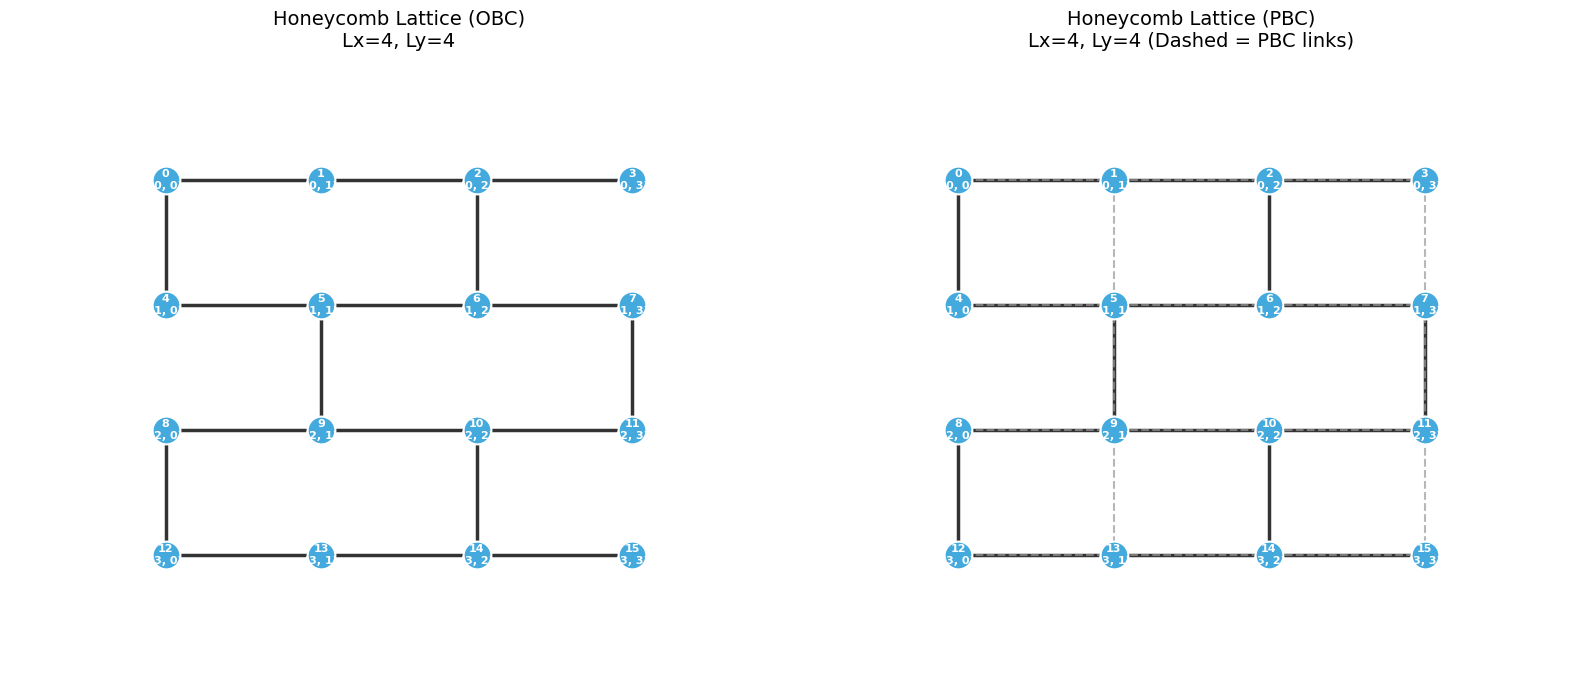

In [9]:
import matplotlib.pyplot as plt
import networkx as nx

# ==========================================
# 2. 绘图函数定义
# ==========================================

def plot_honeycomb_structure(lattice, ax=None, title=None, show_labels=True):
    """
    Visualizes the HoneycombLattice structure using NetworkX and Matplotlib.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # --- 1. create networkx object ---
    G = nx.Graph()
    G.add_nodes_from(range(lattice.N))
    
    # --- 2. compute drawing positions (key step) ---
    pos = {}
    for k in range(lattice.N):
        i, j = lattice.from_index_to_2dcoo(k)
        pos[k] = np.array([j, -i])

    # --- 3. separate normal edges and PBC crossing edges ---
    normal_edges = []
    pbc_edges = []
    
    for u, v in lattice.edges():
        # compute distance between nodes in drawing space
        dist = np.linalg.norm(pos[u] - pos[v])
        # If the distance is too large (e.g., greater than 1.5 units), it indicates a long edge crossing the boundary
        if dist > 1.5:
            pbc_edges.append((u, v))
        else:
            normal_edges.append((u, v))

    print(normal_edges)
    # --- 4. draw ---
    # draw nodes
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=400, 
                           node_color='#4ad', edgecolors='white', linewidths=1.5)
    
    # draw normal edges (solid, dark)
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=normal_edges, 
                           width=2.5, edge_color='#333')
    
    # draw PBC crossing edges (dashed, light gray, to avoid visual clutter)
    if pbc_edges:
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=pbc_edges, 
                               width=1.5, edge_color='#999', style='dashed', alpha=0.7)

    # draw labels (optional)
    if show_labels:
        # construct label text: show "1D index\n(i,j)"
        labels = {}
        for k in range(lattice.N):
            coo = lattice.from_index_to_2dcoo(k)
            labels[k] = f"{k}\n{coo}"
        nx.draw_networkx_labels(G, pos, labels=labels, ax=ax, font_size=8, font_color='white', font_weight='bold')

    # --- 5. adjust plot appearance ---
    if title:
        ax.set_title(title, fontsize=14)
    ax.axis('off') # turn off axis
    # slightly adjust display range to leave some margin
    x_values, y_values = zip(*pos.values())
    ax.set_xlim(min(x_values) - 1, max(x_values) + 1)
    ax.set_ylim(min(y_values) - 1, max(y_values) + 1)


# ==========================================
# 3. run example
# ==========================================

if __name__ == "__main__":
    # set lattice size
    Lx, Ly = 4, 4 # 4 rows 6 columns

    # Instance 1: Open Boundary Conditions
    lat_obc = HoneycombLattice(Lx, Ly, pbc=False)

    # Instance 2: Periodic Boundary Conditions
    lat_pbc = HoneycombLattice(Lx, Ly, pbc=True)

    # Create canvas for side-by-side comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Draw OBC
    plot_honeycomb_structure(lat_obc, ax=axes[0], 
                             title=f"Honeycomb Lattice (OBC)\nLx={Lx}, Ly={Ly}")

    # Draw PBC
    plot_honeycomb_structure(lat_pbc, ax=axes[1], 
                             title=f"Honeycomb Lattice (PBC)\nLx={Lx}, Ly={Ly} (Dashed = PBC links)")

    plt.tight_layout()
    plt.show()